In [10]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import orbax.checkpoint as ocp
from pathlib import Path
from flax.training import orbax_utils


## Buck-converter parameter sampling and model setup

This notebook generates a collection of averaged buck-converter models with randomly sampled physical parameters. The setup mirrors the buck-converter experiments used in the accompanying preprint and is intended as a lightweight, fully reproducible reference implementation.

We sample load resistance, quality factor, and natural frequency over wide ranges to obtain a diverse set of operating conditions. From these quantities, consistent inductance and capacitance values are derived. All states are expressed in per-unit coordinates using global normalization constants.

The averaged continuous-time dynamics are discretized using a forward Euler scheme at a fixed switching frequency. Since explicit Euler discretization can become unstable for certain parameter combinations, we explicitly check the discrete-time eigenvalues and discard unstable models before further use.

All computations are vectorized and implemented in JAX to enable efficient batched simulation and downstream learning experiments.


### Random parameter generation


In [ ]:
# -------------------------------------------------------
# Random key (reproducible)
# -------------------------------------------------------
key = jax.random.PRNGKey(42)
key_R, key_Q, key_w0 = jax.random.split(key, 3)

# -------------------------------------------------------
# Fixed parameters
# -------------------------------------------------------
N_params = 100
V_nom = jnp.full(N_params, 48.0)
f_s = 1e5  # switching frequency [Hz]
dt = 1 / f_s
T_episode = 0.015       # episode duration [s]
T_steps = int(T_episode / dt)
T_steps = 300

# -------------------------------------------------------
# Parameter ranges
# -------------------------------------------------------

# Load resistance (log-uniform!)
R_min = 0.01
R_max = 1000.0

# Quality factor
Q_min = 0.3
Q_max = 3.0

# Natural frequency
w0_min = 2 * jnp.pi * (f_s / 1000)
w0_max = 2 * jnp.pi * (f_s / 10)

# -------------------------------------------------------
# Random sampling
# -------------------------------------------------------

# Log-uniform load resistance
log_R = jax.random.uniform(
    key_R, shape=(N_params,), minval=jnp.log10(R_min), maxval=jnp.log10(R_max)
)
R_load = 10.0 ** log_R

# Uniform Q
Q = jax.random.uniform(
    key_Q, shape=(N_params,), minval=Q_min, maxval=Q_max
)

# Uniform omega_0
w0 = jax.random.uniform(
    key_w0, shape=(N_params,), minval=w0_min, maxval=w0_max
)

# -------------------------------------------------------
# Derived LC parameters
# -------------------------------------------------------
L = R_load / (Q * w0)
C = Q / (R_load * w0)

d = 0.01/2 * jnp.sqrt(C/L)
tau = 1 / (w0*d)

# -------------------------------------------------------
# Pack everything
# -------------------------------------------------------

R_norm = jnp.max(R_load)
L_norm = jnp.max(L)
C_norm = jnp.max(C)

buck_params = {
    "V_nom": V_nom,
    "R_load": R_load,
    "L": L,
    "C": C,
    "Q": Q,
    "w0": w0,
    "tau": tau,
    "d": d,
}

### Averaged buck dynamics (Euler step)


In [ ]:
def buck_step_single(x, d, buck_params):
    """
    One step of averaged buck dynamics (single system)
    x      : (2,) [i_L_pu, v_C_pu]
    d      : scalar duty ratio
    env    : dict with V_in_pu, R_load
    params : dict with L, C, R_L
    """

    # unpack
    i_L_pu, v_C_pu, _ = x
    V_nom = buck_params["V_nom"]
    R_load = buck_params["R_load"]    
    I_in = V_nom / R_load

    L = buck_params["L"]
    C = buck_params["C"]
    R_L = 0.01

    # de-normalize
    i_L = i_L_pu * I_in
    v_C = v_C_pu * V_nom

    # averaged dynamics
    di_L = ((d * V_nom - v_C - i_L * R_L) / L) / f_s
    dv_C = ((i_L - v_C / R_load) / C) / f_s
    
    # Euler step
    i_L_next = i_L +  di_L 
    v_C_next = v_C +  dv_C

    return jnp.array([
        i_L_next / I_in,
        v_C_next / V_nom,
        d,
    ])

### Discrete-time stability filtering

In [4]:
def buck_is_stable(buck_params):
    R = buck_params["R_load"]
    L = buck_params["L"]
    C = buck_params["C"]
    f_s = 1e5
    R_L = 0.01

    A_euler = jnp.stack([
        jnp.stack([1 - R_L/(L*f_s), -1/(L*f_s)], axis=-1),
        jnp.stack([1/(C*f_s), 1 - 1/(R*C*f_s)], axis=-1)
    ], axis=-2)

    eigvals = jnp.linalg.eigvals(A_euler)
    return jnp.all(jnp.abs(eigvals) < 1.0, axis=-1)


stable_mask = buck_is_stable(buck_params)
for k in buck_params:
    buck_params[k] = buck_params[k][stable_mask]


## Graph representation of the buck converter

We encode the buck-converter topology as a fixed typed graph. Component nodes (source, switch, diode, inductor, capacitor, load) and electrical net nodes are represented explicitly, following the bipartite component–net structure described in the paper.

Each node is assigned a discrete type ID. Edges correspond to electrical connections between component terminals and nets and are represented as pairs of directed edges to support message passing.

This graph structure is fixed for the buck topology; only node features and physical parameters vary across sampled converters.


In [5]:
# -------------------------------------------------------
# Buck converter graph definition (fixed for this topology)
# -------------------------------------------------------

NODE_TYPES = {
    "src": 0, "switch": 1, "diode": 2,
    "inductor": 3, "capacitor": 4, "resistor": 5,
    "net": 6,
}
num_type = len(NODE_TYPES)

# Node indexing (example: 6 element + 4 net nodes)
# v_src, v_S, v_D, v_L, v_C, v_R, n_in, n_sw, n_o, n_g
N = 10
node_type_ids = jnp.array([
    NODE_TYPES["src"],      # 0
    NODE_TYPES["switch"],   # 1
    NODE_TYPES["diode"],    # 2
    NODE_TYPES["inductor"], # 3
    NODE_TYPES["capacitor"],# 4
    NODE_TYPES["resistor"], # 5
    NODE_TYPES["net"],      # 6 n_in
    NODE_TYPES["net"],      # 7 n_sw
    NODE_TYPES["net"],      # 8 n_o
    NODE_TYPES["net"],      # 9 n_g
], dtype=jnp.int32)

# Edges: undirected, represented as two directed edges for message passing
edges = [
    (0, 6), (6, 0),
    (0, 9), (9, 0),
    (1, 6), (6, 1),
    (1, 7), (7, 1),
    (2, 7), (7, 2),
    (2, 9), (9, 2),
    (3, 7), (7, 3),
    (3, 8), (8, 3),
    (4, 8), (8, 4),
    (4, 9), (9, 4),
    (5, 8), (8, 5),
    (5, 9), (9, 5),
]
senders = jnp.array([e[0] for e in edges], dtype=jnp.int32)
receivers = jnp.array([e[1] for e in edges], dtype=jnp.int32)
E = senders.shape[0]


## GNN-based control policy

We define a lightweight graph neural network that maps the current converter state and reference to a duty-cycle command.

Node features encode local electrical quantities (e.g., inductor current, capacitor voltage), normalized component parameters, and the reference signal. Message passing is performed for a fixed number of iterations using simple sum aggregation.

After message passing, the duty cycle is predicted from the embedding of the switch node via a small readout head with a sigmoid output to enforce bounds.


In [ ]:
# -------------------------------------------------------
# GNN policy definition
# -------------------------------------------------------

hidden_dim = 16
node_feat_dim = 3   # TODO: Correct?

def init_params(key):
    k1, k2, k3 = jax.random.split(key, 3)

    W_u1 = 0.1 * jax.random.normal(k1, (2 * hidden_dim, hidden_dim))
    b_u1 = jnp.zeros((hidden_dim,))

    W_in = 0.1 * jax.random.normal(k2, (node_feat_dim, hidden_dim))
    b_in = jnp.zeros((hidden_dim,))

    W_out = 0.1 * jax.random.normal(k3, (hidden_dim, 1))
    b_out = jnp.zeros((1,))

    return {
        "W_u1": W_u1, "b_u1": b_u1,
        "W_in": W_in, "b_in": b_in,
        "W_out": W_out, "b_out": b_out,
    }

def gnn_policy_apply(params, x, u_ref_pu, buck_params):
    """
    x          : (2,) state [i_L_pu, v_C_pu, d]
    env_state  : (V_in_pu, R_load_pu, V_ref_pu)
    returns duty ratio d in [0,1]
    """
    i_L_pu, v_C_pu, d = x
    L = buck_params["L"]
    C = buck_params["C"]
    R_load = buck_params["R_load"]

    feats = jnp.zeros((N, node_feat_dim))
    feats = feats.at[0, :1].set(jnp.array([u_ref_pu]))
    feats = feats.at[1, :2].set(jnp.array([u_ref_pu, d]))
    feats = feats.at[2, :2].set(jnp.array([u_ref_pu, d]))
    feats = feats.at[3, :3].set(jnp.array([u_ref_pu, i_L_pu, L / L_norm]))
    feats = feats.at[4, :3].set(jnp.array([u_ref_pu, v_C_pu, C / C_norm ]))
    feats = feats.at[5, :4].set(jnp.array([u_ref_pu - v_C_pu, v_C_pu / (R_load / R_norm ), R_load /R_norm]))
    feats = feats.at[6, :1].set(jnp.array([u_ref_pu]))
    feats = feats.at[7, :2].set(jnp.array([u_ref_pu, d]))
    feats = feats.at[8, :2].set(jnp.array([u_ref_pu, v_C_pu]))
    feats = feats.at[9, :1].set(jnp.array([u_ref_pu]))
    
    h = jnp.tanh(feats @ params["W_in"] + params["b_in"])

    def message_pass(h):
        h_s = h[senders]
        # aggregate by sum at receivers
        m_agg = jnp.zeros_like(h)
        counts = jnp.bincount(receivers, length=m_agg.shape[0])
        h_s_norm = h_s / counts[receivers][..., None]

        m_agg = m_agg.at[receivers].add(h_s_norm)

        # node update
        h_in = jnp.concatenate([h, m_agg], axis=-1)
        h_next = jnp.tanh(h_in @ params["W_u1"] + params["b_u1"])

        return h_next

    def body_fun(_, h):
        return message_pass(h)

    h = jax.lax.fori_loop(
        0,
        4,
        body_fun,
        h,
    )

    # global readout from switch node embedding (node 1)
    h_switch = h[1]
    d = jax.nn.sigmoid(h_switch @ params["W_out"] + params["b_out"])
    return d[0]


## Cost function and closed-loop rollout

Training is performed using episodic rollouts of the averaged buck dynamics in closed loop with the GNN policy.

The stage cost consists of:
- a voltage tracking term,
- a soft penalty on inductor current limit violations,
- a smoothness penalty on duty-cycle changes.

For each episode, a random voltage reference is sampled and the system is simulated forward for a fixed horizon. Costs are accumulated over time and averaged across the batch of randomly sampled converter instances.


In [7]:
# -------------------------------------------------------
# Cost function and episode rollout
# -------------------------------------------------------

I_lim_pu = 2.0      # soft current limit (per-unit)

def stage_cost(x, d_prev, u_ref_pu):
    w_v = 1.0
    w_i = 10.0
    w_du = 0.1

    i_L_pu, v_C_pu, d = x

    # voltage tracking error
    e_v = v_C_pu - u_ref_pu
    cost_v = w_v * e_v**2

    # soft current constraint
    over = jnp.maximum(0.0, jnp.abs(i_L_pu) - I_lim_pu)
    cost_i = w_i * over**2

    # control smoothness
    cost_du = w_du * (d - d_prev)**2

    return cost_v + cost_i + cost_du

def rollout_episode(params, buck_params, key):
    # initialize environment and state
    key_ref, key_dyn = jax.random.split(key, 2)
    ref = jax.random.uniform(key_ref, minval=0.0, maxval=1.0)
    i0 = 0.0
    u0 = 0.0
    x0 = jnp.array([i0, u0, 1.0])   # zero current and voltage

    def body(carry, key_t):
        x, ref, cost_acc = carry
        _, _, d_prev = x

        # policy
        d = gnn_policy_apply(params, x, ref, buck_params)
        d = jnp.clip(d, 0.0, 1.0)

        # dynamics step
        x_next = buck_step_single(x, d, buck_params)

        # cost
        c = stage_cost(x_next, d_prev, ref)

        cost_acc = cost_acc + c
        return (x_next, ref, cost_acc), None

    keys = jax.random.split(key_dyn, T_steps)
    (_, _, cost_acc), _ = jax.lax.scan(
        body,
        (x0, ref, 0.0),
        keys
    )
    return cost_acc  # traj: (x, env_state, d, c) over time

# vectorized over batch of episodes
def batched_rollout(params, key, buck_params):
    keys = jax.random.split(key, buck_params["V_nom"].shape[0])
    
    costs = jax.vmap(rollout_episode, in_axes=(None, 0, 0))(params, buck_params, keys)
    return jnp.mean(costs)


## Policy training

The GNN policy parameters are optimized end-to-end using gradient-based optimization. Gradients are obtained by differentiating through the closed-loop rollouts.

We use Adam with a fixed learning rate and train for a small number of iterations as a proof of concept. The learning curve below shows the mean episode cost over training iterations.


Iter    1, mean episode cost = 24.093
Iter    2, mean episode cost = 26.872
Iter    3, mean episode cost = 25.665
Iter    4, mean episode cost = 24.650
Iter    5, mean episode cost = 27.084
Iter    6, mean episode cost = 22.634
Iter    7, mean episode cost = 25.778
Iter    8, mean episode cost = 23.025
Iter    9, mean episode cost = 24.372
Iter   10, mean episode cost = 25.312
Iter   11, mean episode cost = 22.199
Iter   12, mean episode cost = 21.782
Iter   13, mean episode cost = 22.212
Iter   14, mean episode cost = 23.812
Iter   15, mean episode cost = 21.796
Iter   16, mean episode cost = 22.894
Iter   17, mean episode cost = 19.439
Iter   18, mean episode cost = 19.558
Iter   19, mean episode cost = 19.077
Iter   20, mean episode cost = 18.006
Iter   21, mean episode cost = 16.838
Iter   22, mean episode cost = 16.975
Iter   23, mean episode cost = 14.855
Iter   24, mean episode cost = 14.209
Iter   25, mean episode cost = 11.614
Iter   26, mean episode cost = 12.244
Iter   27, m

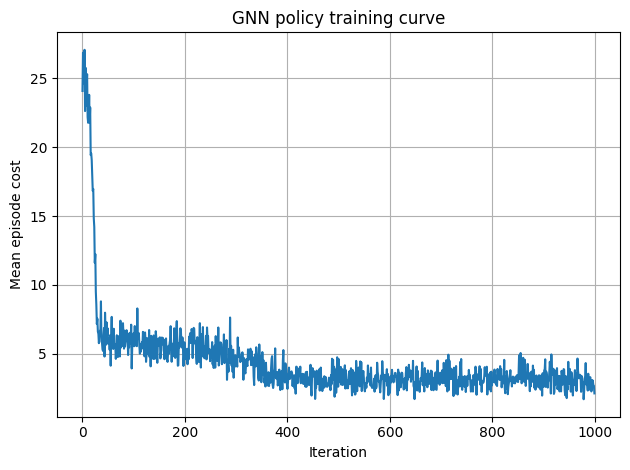

In [8]:
# -------------------------------------------------------
# Training loop
# -------------------------------------------------------
T_steps = 250

key, key_params = jax.random.split(key)
params = init_params(key_params)
optimizer = optax.adam(3e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, buck_params, opt_state, key):
    def loss_fn(p, k):
        cost_mean = batched_rollout(p, k, buck_params)
        return cost_mean

    loss, grads = jax.value_and_grad(loss_fn)(params, key)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

num_iters = 1000
loss_history = []

for it in range(num_iters):
    key, key_train = jax.random.split(key)
    params, opt_state, loss_val = train_step(params, buck_params, opt_state, key_train)
    loss_history.append(float(loss_val))
    print(f"Iter {it+1:4d}, mean episode cost = {loss_val:.3f}")

# Plot learning curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Mean episode cost")
plt.title("GNN policy training curve")
plt.grid(True)
plt.tight_layout()
plt.show()

## Checkpointing

Model parameters, optimizer state, and the filtered set of buck parameters are saved using Orbax. This allows training to be resumed and trained policies to be reused without rerunning the full optimization.


In [ ]:
orbax_checkpointer = ocp.PyTreeCheckpointer()

In [12]:
ckpt_dir = Path.cwd() / "ckpt_gnn_final"

ckpt = {
    "params": params,
    "buck_params": buck_params,
    "opt_state": opt_state,
}
orbax_checkpointer = ocp.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save(ckpt_dir, ckpt, save_args=save_args)

In [ ]:
ckpt = orbax_checkpointer.restore(Path.cwd() / "ckpt_gnn_final" )
params = ckpt["params"]
buck_params = ckpt["buck_params"]
opt_state = ckpt["opt_state"]

## Optimal-control baseline (open-loop MPC)

To obtain a performance reference, we compute an approximate optimal-control (OC) solution for each buck converter and reference value.

For a fixed reference, we directly optimize the duty-cycle sequence over the full episode horizon using gradient descent. The same stage cost as for policy training is used. Since the system model is fully differentiable, gradients are obtained by backpropagating through the rollout.

This open-loop solution serves as a near-optimal baseline for comparison with the learned GNN policy.


In [14]:
T_steps = 250

def rollout_single_episode_mpc(u_params, buck_param, ref):
    x0 = jnp.array([0.0, 0.0, 0.0])
    d_prev0 = 0.0
    cost0 = 0.0

    def body(carry, t):
        x, d_prev, cost = carry

        d = jnp.clip(u_params[t], 0.0, 1.0)
        x_next = buck_step_single(x, d, buck_param)

        stage = stage_cost(x_next, d_prev, ref)
        cost_next = cost + stage

        log = {
            "v_C_pu": x_next[1],
            "d": d,
            "stage_cost": stage,
        }

        return (x_next, d, cost_next), log

    timesteps = jnp.arange(T_steps)
    (xT, dT, total_cost), traj = jax.lax.scan(
        body,
        (x0, d_prev0, cost0),
        timesteps,
    )

    mean_cost = total_cost / T_steps
    return traj, mean_cost


def mpc_loss(u_params, buck_param, ref):
    _, mean_cost = rollout_single_episode_mpc(u_params, buck_param, ref)
    return mean_cost


@jax.jit
def gd_step(u, buck_param, ref, lr):
    loss, grad = jax.value_and_grad(mpc_loss)(u, buck_param, ref)
    return u - lr * grad, loss


def optimize_mpc_for_one_buck_and_ref(
    buck_param,
    ref,
    t_steps,
    num_iters=500,
    lr=1e-2,
):
    u0 = jnp.ones(t_steps) * 0.5

    def body(u, _):
        u, loss = gd_step(u, buck_param, ref, lr)
        return u, loss

    u_opt, losses = jax.lax.scan(body, u0, None, length=num_iters)
    return u_opt, losses[-1]


optimize_over_bucks = jax.vmap(
    optimize_mpc_for_one_buck_and_ref,
    in_axes=(0, None, None, None, None),
)

refs = jnp.linspace(0.0, 1.0, 11)

def optimize_for_ref(ref):
    return optimize_over_bucks(
        buck_params,
        ref,
        T_steps + 5,
        10000,
        1e-1,
    )

optimize_for_refs = jax.vmap(optimize_for_ref)

u_opt, final_loss = optimize_for_refs(refs)


## Closed-loop evaluation of the GNN policy

We evaluate the trained GNN controller in closed loop across the full set of sampled buck converters and a range of reference values.

For each (buck, reference) pair, we roll out the averaged dynamics and compute the mean squared voltage tracking error. Results are stored per buck and per reference, and then aggregated to obtain:
- mean MSE per buck (averaged over references),
- mean MSE per reference (averaged over bucks).

These statistics are used for both qualitative inspection and quantitative comparison against the optimal-control baseline.


In [16]:
def rollout_single_episode(params, buck_params, key, ref):
    key_env, key_dyn = jax.random.split(key)

    x0 = jnp.array([0.0, 0.0, 0.0])

    def body(carry, key_t):
        x, ref = carry
        i_L_pu, v_C_pu, d_prev = x

        # policy
        d = gnn_policy_apply(params, x, ref, buck_params)
        d = jnp.clip(d, 0.0, 1.0)

        # dynamics
        x_next = buck_step_single(x, d, buck_params)

        # log signals
        log = {
            "i_L_pu": x_next[0],
            "v_C_pu": x_next[1],
            "d": d,
            "ref": ref,
        }

        return (x_next, ref), log

    keys = jax.random.split(key_dyn, T_steps)
    (_, _), traj = jax.lax.scan(body, (x0, ref), keys)

    return traj

key, key_eval = jax.random.split(key)
results_gnn = {}

for ref in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    traj = jax.vmap(rollout_single_episode,in_axes=(None, 0, None, None))(params, buck_params, key_eval, ref)

    for buck_idx, (ref_tracked, v_C_pu_tracked) in enumerate(zip(traj["ref"], traj["v_C_pu"])):
        buck_dict2 = results_gnn.setdefault(str(buck_idx), {})
        buck_dict2[str(ref)] = jnp.mean((ref_tracked - v_C_pu_tracked) ** 2)




In [17]:
def mean_mse_per_buck(results):
    return {
        buck_idx: jnp.mean(jnp.array(list(ref_dict.values())))
        for buck_idx, ref_dict in results.items()
    }

mean_buck_gnn = mean_mse_per_buck(results_gnn)

def mean_mse_per_ref(results):
    # collect refs from first buck (structure is shared)
    refs = next(iter(results.values())).keys()

    return {
        ref: jnp.mean(
            jnp.array([results[buck_idx][ref] for buck_idx in results])
        )
        for ref in refs
    }

mean_ref_gnn = mean_mse_per_ref(results_gnn)


In [18]:
def results_to_array(results):
    buck_ids = sorted(results.keys(), key=int)
    refs = sorted(next(iter(results.values())).keys(), key=float)

    arr = jnp.array([
        [results[b][r] for r in refs]
        for b in buck_ids
    ])  # shape: (num_bucks, num_refs)

    return arr, buck_ids, refs
arr_gnn, buck_ids, refs = results_to_array(results_gnn)

mean_per_buck_gnn = arr_gnn.mean(axis=1)
mean_per_ref_gnn = arr_gnn.mean(axis=0)


In [21]:
import numpy as np
# Buck indices as strings
buck_idxs = np.array(list(mean_buck_gnn.keys()))
# Corresponding mean MSEs
mse_values = np.array(list(mean_buck_gnn.values()))

num_select = 3  # top 3

worst_idx_order = np.argsort(mse_values)[-num_select:][::-1]  # descending
worst_bucks = buck_idxs[worst_idx_order]

print("Worst 3 bucks (highest MSE):", worst_bucks)

best_idx_order = np.argsort(mse_values)[:num_select]  # ascending
best_bucks = buck_idxs[best_idx_order]

print("Best 3 bucks (lowest MSE):", best_bucks)

Worst 3 bucks (highest MSE): ['4' '29' '27']
Best 3 bucks (lowest MSE): ['81' '26' '10']


## Time-domain comparison: GNN vs. optimal control

For selected buck converters, we compare the closed-loop trajectories of the trained GNN policy against the optimal-control solution.

We plot output voltage, inductor current, and duty cycle over time for a fixed reference. Reported MSE values allow direct quantitative comparison, while the trajectories provide qualitative insight into transient behavior and constraint handling.


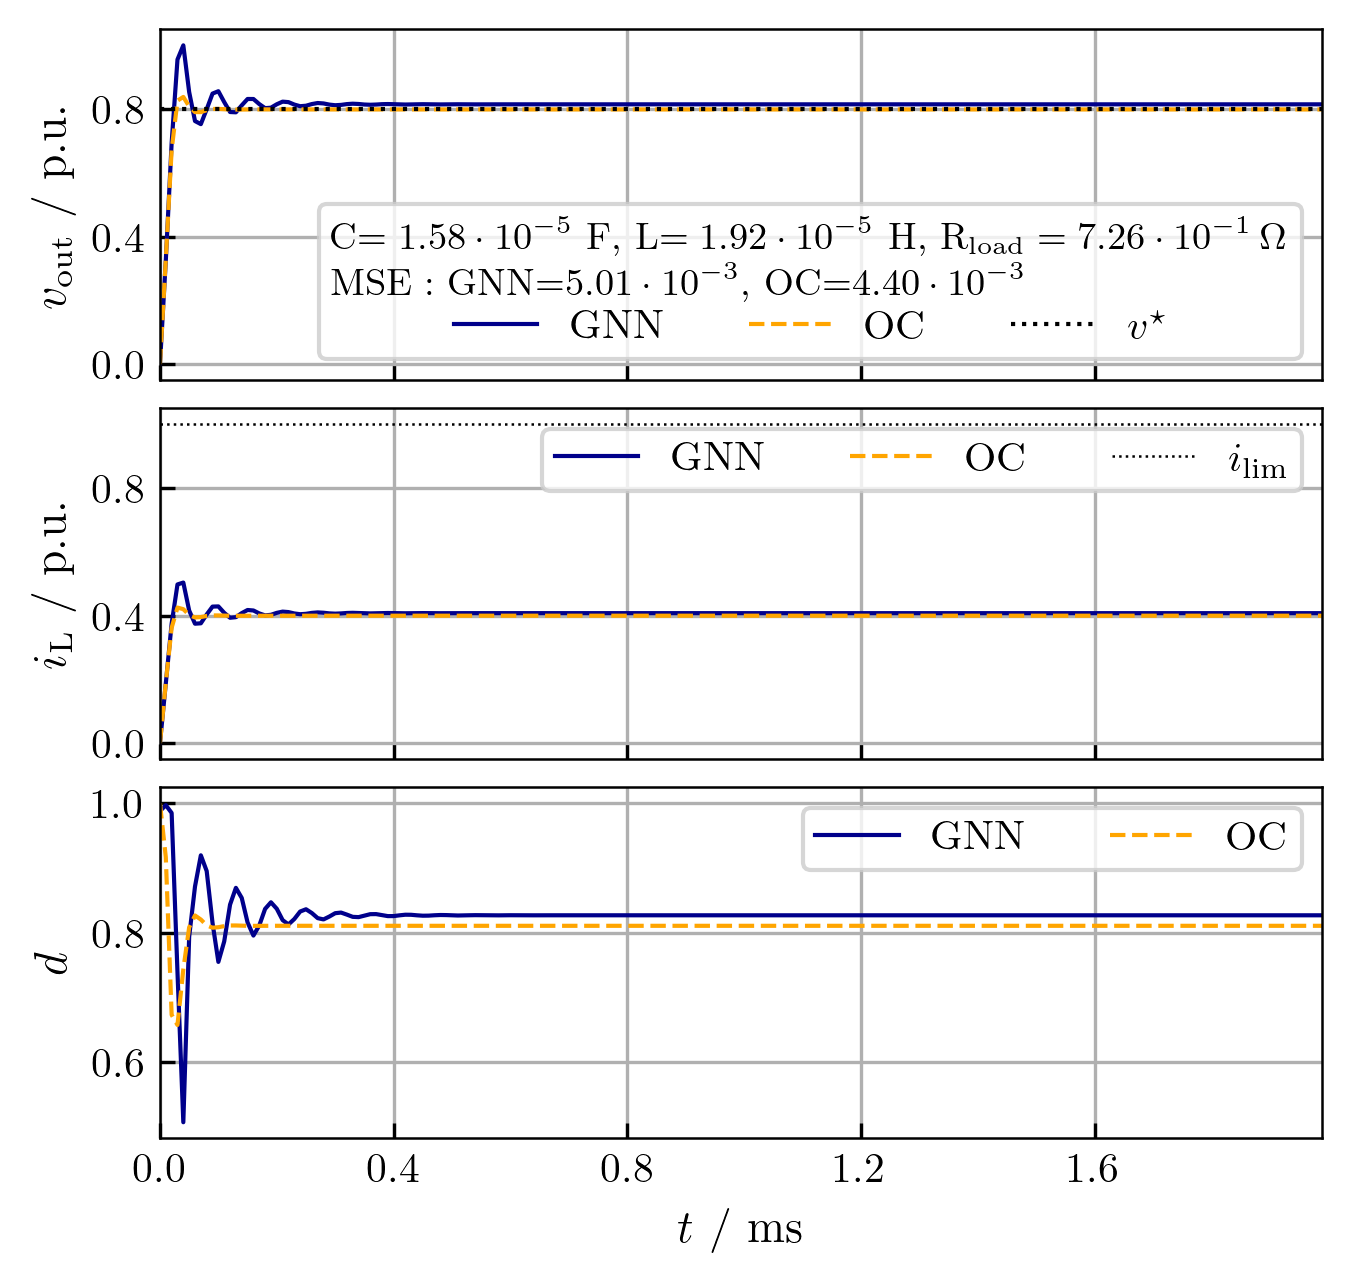

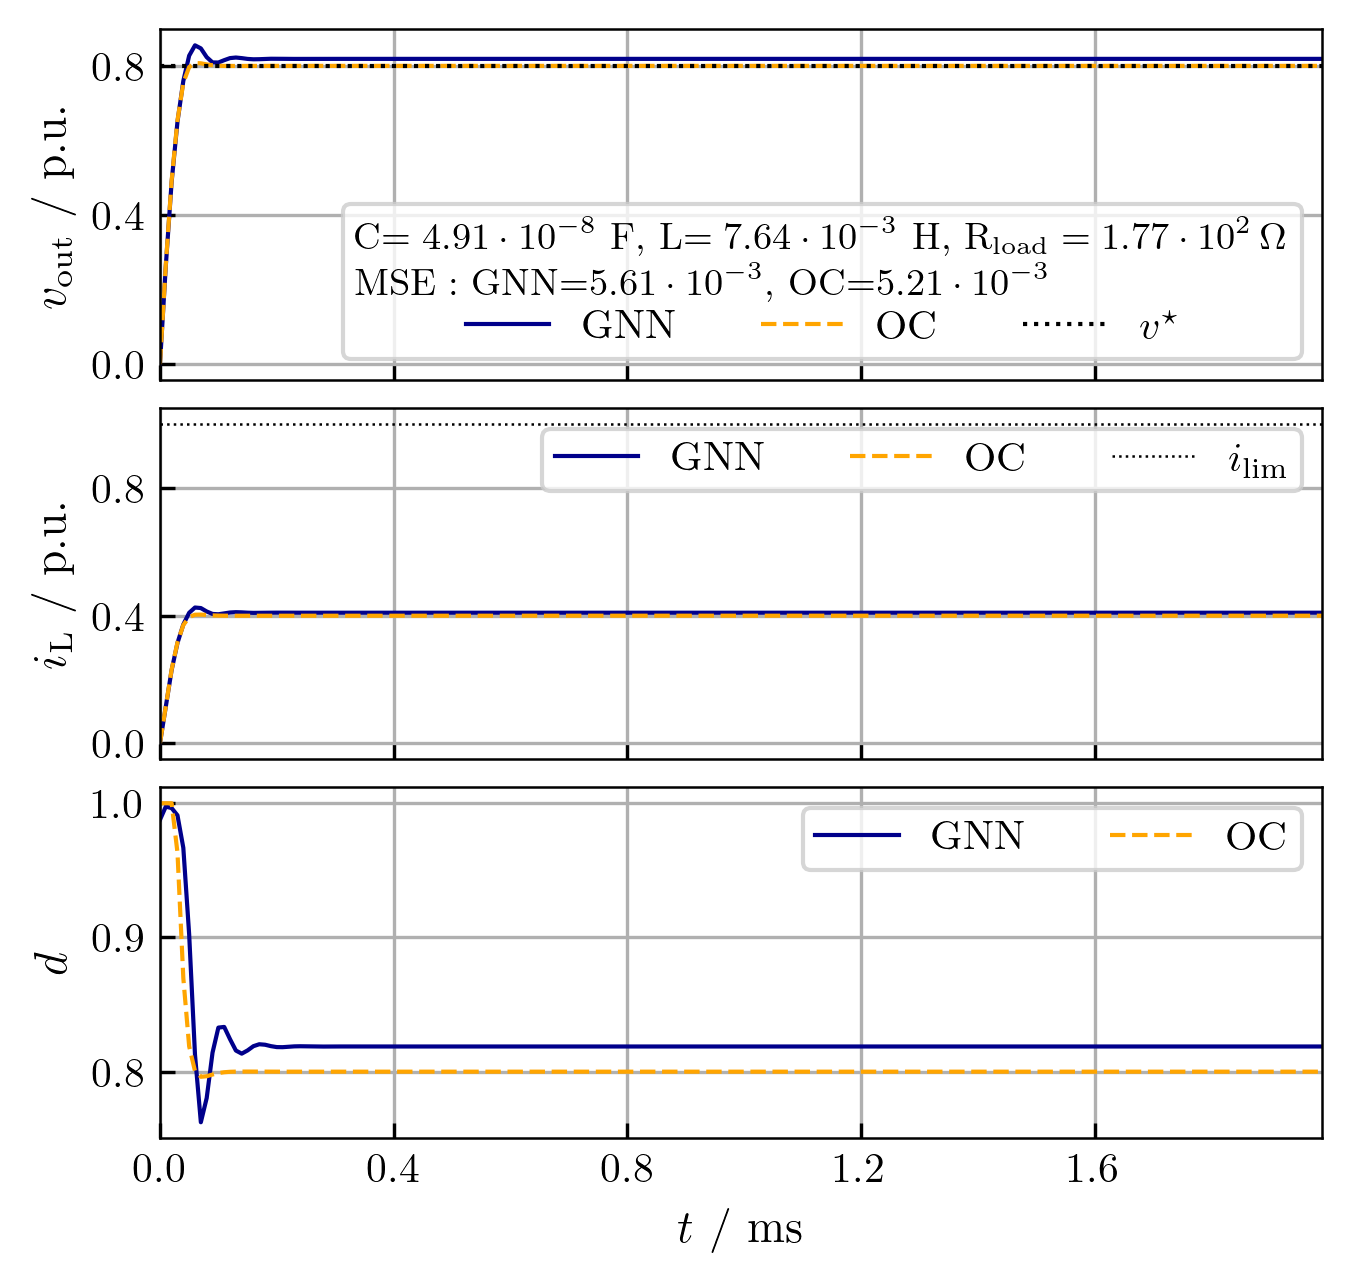

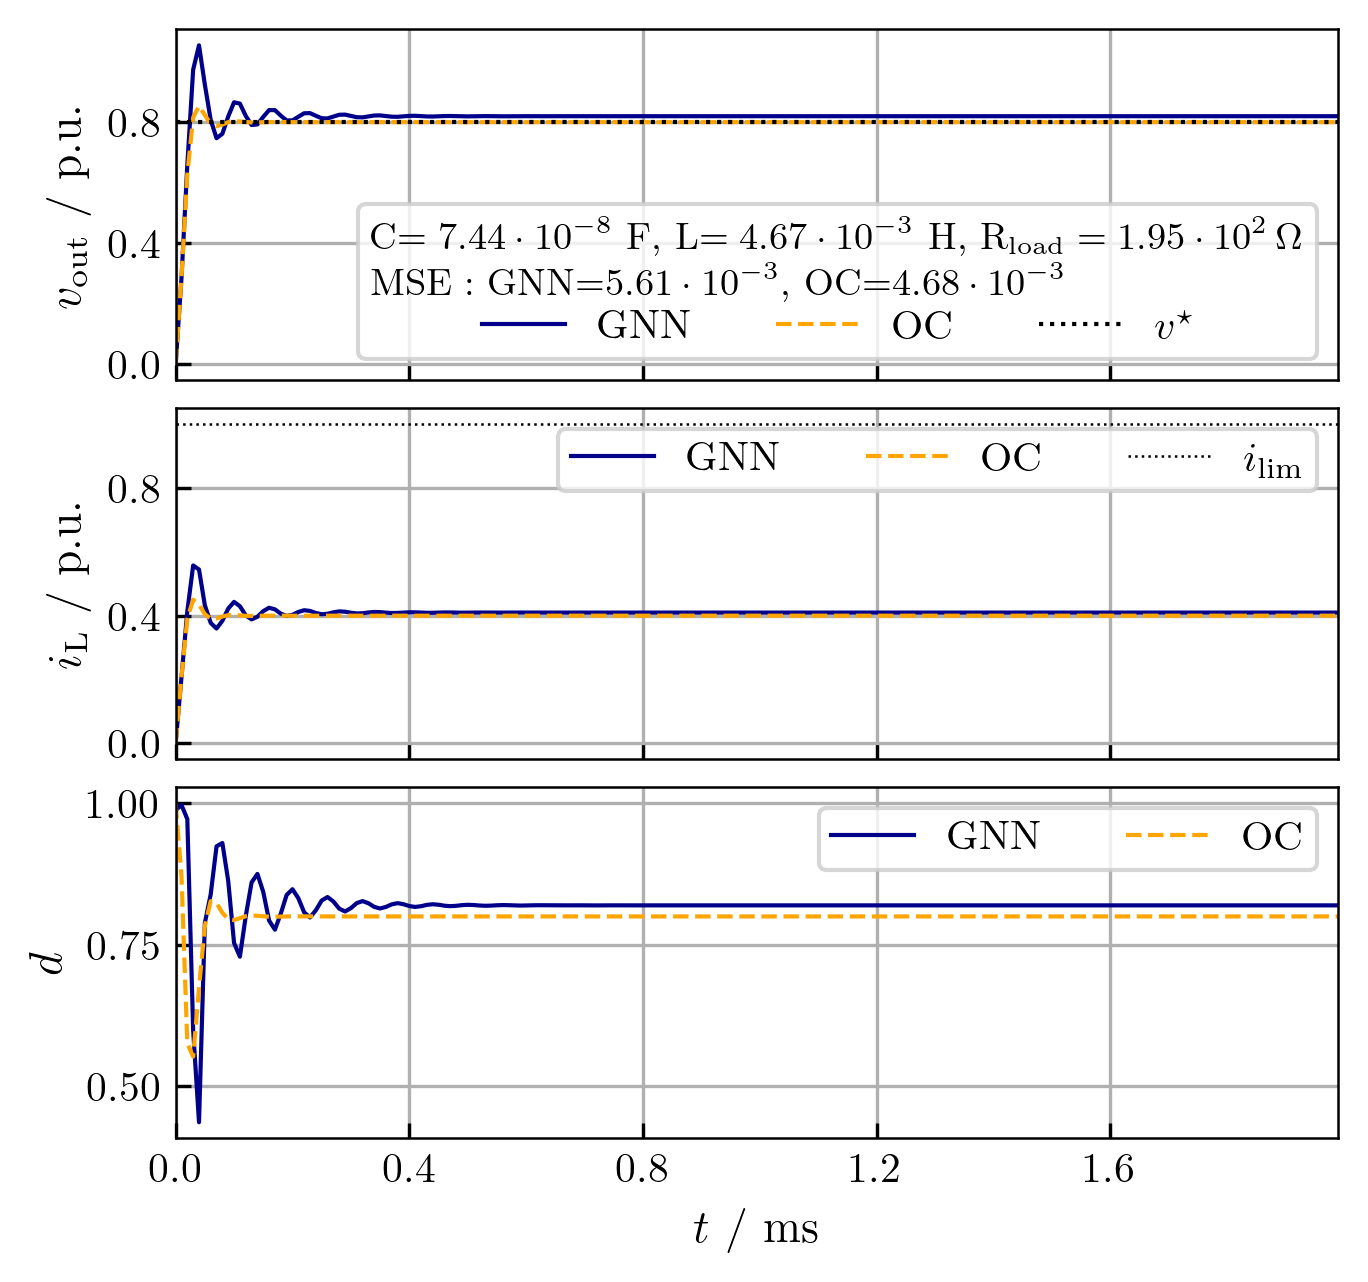

In [ ]:
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

rc('text', usetex=True)
rc('font', family='serif')
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

plt.rcParams.update({
    'text.latex.preamble': r"""
        \usepackage{amsmath,amssymb}
    """,
    'lines.linewidth': 1.0,
    'axes.linewidth': 0.6,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

ckpt = orbax_checkpointer.restore(Path.cwd() / "ckpt_gnn_final" )
params = ckpt["params"]
buck_params = ckpt["buck_params"]
opt_state = ckpt["opt_state"]

refs = jnp.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
T_steps = 200

def rollout_single_episode_mpc(u_params, buck_param, ref):
    x0 = jnp.array([0.0, 0.0, 0.0])

    def body(carry, t):
        x = carry

        d = jnp.clip(u_params[t], 0.0, 1.0)
        x_next = buck_step_single(x, d, buck_param)

        log = {
            "i_L_pu": x_next[0],
            "v_C_pu": x_next[1],
            "d": d,
            "ref": ref,
        }

        return x_next, log

    timesteps = jnp.arange(T_steps)
    _, traj = jax.lax.scan(body, x0, timesteps)

    return traj

def ref_to_index(ref, refs):
    return int(jnp.argmin(jnp.abs(refs - ref)))

def extract_buck_params(buck_params, buck_idx):
    return jax.tree_util.tree_map(lambda x: float(x[buck_idx]), buck_params)

def get_mpc_traj(u_opt, refs, ref, buck_idx):
    ref_idx = ref_to_index(ref, refs)
    u = u_opt[ref_idx, buck_idx]
    buck_param = jax.tree_util.tree_map(lambda x: x[buck_idx], buck_params)
    return rollout_single_episode_mpc(u, buck_param, ref)

def rollout_single_episode(params, buck_params, key, ref):
    key_env, key_dyn = jax.random.split(key)

    x0 = jnp.array([0.0, 0.0, 0.0])

    def body(carry, key_t):
        x, ref = carry
        i_L_pu, v_C_pu, d_prev = x

        # policy
        d = gnn_policy_apply(params, x, ref, buck_params)
        d = jnp.clip(d, 0.0, 1.0)

        # dynamics
        x_next = buck_step_single(x, d, buck_params)

        # log signals
        log = {
            "i_L_pu": x_next[0],
            "v_C_pu": x_next[1],
            "d": d,
            "ref": ref,
        }

        return (x_next, ref), log

    keys = jax.random.split(key_dyn, T_steps)
    (_, _), traj = jax.lax.scan(body, (x0, ref), keys)

    return traj

key, key_eval = jax.random.split(key)
results_gnn = {}

traj = jax.vmap(rollout_single_episode,in_axes=(None, 0, None, None))(params, buck_params, key_eval, 0.8)
def print_plot_tpel(
    traj_gnn,
    buck_idx,
    ref,
    u_opt,
    refs,
):
    buck_p = extract_buck_params(buck_params, buck_idx)

    C = buck_p["C"]
    L = buck_p["L"]
    R_load = buck_p["R_load"]

    # -------- Extract GNN --------
    i_L = traj_gnn["i_L_pu"][buck_idx]
    v_C = traj_gnn["v_C_pu"][buck_idx]
    d_gnn = traj_gnn["d"][buck_idx]
    v_ref = traj_gnn["ref"][buck_idx]

    # -------- Extract MPC --------
    traj_mpc = get_mpc_traj(u_opt, refs, ref, buck_idx)
    i_L_mpc = traj_mpc["i_L_pu"]
    v_C_mpc = traj_mpc["v_C_pu"]
    d_mpc = traj_mpc["d"]

    # -------- Metrics --------
    gnn_mse = jnp.mean((v_C - ref) ** 2)
    mpc_mse = jnp.mean((v_C_mpc - ref) ** 2)

    # -------- Time --------
    t = jnp.arange(T_steps) * dt * 1000

    fig, axs = plt.subplots(
        3, 1,
        figsize=(5.0, 4.8),
        sharex=True,
        dpi=300
    )


    axs[0].plot(
        t, v_C,
        label=r'GNN',
        color='darkblue'
    )
    axs[0].plot(
        t, v_C_mpc ,
        linestyle='--',
        label=r'OC',
        color='orange'
    )
    axs[0].plot(
        t, v_ref,
        linestyle=':',
        color='black',
        label=r'$v^\star$'
    )
    def sci_latex(x, precision=2):
        """
        Format number as LaTeX: a.bb \\times 10^{c}
        """
        if x == 0:
            return rf"$0$"

        exp = int(np.floor(np.log10(abs(x))))
        mant = x / 10**exp

        return rf"${mant:.{precision}f} \cdot 10^{{{exp}}}$"

    axs[0].set_ylabel(r'$v_\mathrm{out}$ / p.u.')
    param_line = (
        rf"C$={sci_latex(float(C))[1:-1]}$ F,\ "
        rf"L$={sci_latex(float(L))[1:-1]}$ H,\ "
        rf"$\mathrm{{R}}_\mathrm{{load}}={sci_latex(float(R_load))[1:-1]}\,\Omega$"
    )

    mse_line = (
        rf"$\mathrm{{MSE}}:$ "
        rf"GNN={sci_latex(float(gnn_mse))}, "
        rf"OC={sci_latex(float(mpc_mse))}"
    )

    title = param_line + "\n" + mse_line
    axs[0].legend(
        loc='lower right',
        ncol=3,
        title=title,
        title_fontsize=9,
        frameon=True,
        borderpad=0.3,
        labelspacing=0.2
    )
    axs[0].grid(True)
    axs[0].yaxis.set_major_locator(ticker.MaxNLocator(3))

    # ================= Current =================
    i_L = jnp.concatenate([jnp.array([0.0]), i_L[:-1]])
    i_L_mpc = jnp.concatenate([jnp.array([0.0]), i_L_mpc[:-1]])

    axs[1].plot(
        t, i_L / 2,
        label=r'GNN',
        color='darkblue'
    )
    axs[1].plot(
        t, i_L_mpc / 2,
        linestyle='--',
        label=r'OC',
        color='orange'
    )
    axs[1].axhline(
        I_lim_pu / 2,
        color='black',
        linestyle=':',
        linewidth=0.6,
        label=r'$i_\mathrm{lim}$'
    )

    axs[1].set_ylabel(r'$i_\mathrm{L}$ / p.u.')
    axs[1].legend(
        loc='upper right',
        ncol=3,
        frameon=True,
        borderpad=0.3,
        labelspacing=0.2
    )
    axs[1].grid(True)
    axs[1].yaxis.set_major_locator(ticker.MaxNLocator(3))

    # ================= Duty =================
    axs[2].plot(
        t, d_gnn,
        label=r'GNN',
        color='darkblue'
    )
    axs[2].plot(
        t, d_mpc,
        linestyle='--',
        label=r'OC',
        color='orange'
    )

    axs[2].set_ylabel(r'$d$')
    axs[2].set_xlabel(r'$t$ / ms')
    axs[2].legend(
        loc='upper right',
        ncol=2,
        frameon=True,
        borderpad=0.3
    )
    axs[2].grid(True)
    axs[2].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[2].xaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[-1].set_xlim(t[0], t[-1])
    # -------- Layout --------
    fig.subplots_adjust(hspace=0.08)
    plt.show()

ref = 0.8

traj_gnn = jax.vmap(
    rollout_single_episode,
    in_axes=(None, 0, None, None)
)(params, buck_params, key_eval, ref)

for buck_idx in best_bucks:
    print_plot_tpel(
        traj_gnn,
        int(buck_idx),
        ref,
        u_opt,
        refs,
    )


## Aggregate performance metrics

We compute the average tracking MSE per buck for both controllers:
- GNN policy (closed loop),
- optimal-control baseline.

To keep the evaluation efficient, buck-specific parameters are sliced once outside the JIT-compiled functions. The resulting per-buck MSE values form the basis for the statistical comparisons below.


In [ ]:
def gnn_mse_for_one_buck(params, buck_param, key, refs):
    def one_ref_mse(ref):
        traj = rollout_single_episode(
            params,
            buck_param,
            key,
            ref
        )
        return jnp.mean((traj["v_C_pu"] - ref) ** 2)

    mse_refs = jax.vmap(one_ref_mse)(refs)
    return jnp.mean(mse_refs)

def oc_mse_for_one_buck_idx(u_opt_buck, refs, buck_param, ref_idx):
    ref = refs[ref_idx]

    traj = rollout_single_episode_mpc(
        u_opt_buck[ref_idx],   # already sliced
        buck_param,
        ref,
    )

    return jnp.mean((traj["v_C_pu"] - ref) ** 2)

def oc_mse_for_one_buck(u_opt_buck, refs, buck_param):
    ref_indices = jnp.arange(len(refs))

    mse_refs = jax.vmap(
        lambda i: oc_mse_for_one_buck_idx(
            u_opt_buck, refs, buck_param, i
        )
    )(ref_indices)

    return jnp.mean(mse_refs)


gnn_mse_for_one_buck_jit = jax.jit(gnn_mse_for_one_buck)
oc_mse_for_one_buck_jit  = jax.jit(oc_mse_for_one_buck)

def compute_avg_mse_per_buck_fast(
    params,
    buck_params,
    u_opt,
    refs,
    key,
):
    n_bucks = buck_params["C"].shape[0]

    mse_gnn = []
    mse_oc = []

    for b in range(n_bucks):
        buck_param = jax.tree_util.tree_map(lambda x: x[b], buck_params)
        u_opt_buck = u_opt[:, b]

        mse_gnn.append(
            gnn_mse_for_one_buck_jit(params, buck_param, key, refs)
        )

        mse_oc.append(
            oc_mse_for_one_buck_jit(u_opt_buck, refs, buck_param)
        )

    return jnp.stack(mse_gnn), jnp.stack(mse_oc)


In [29]:
mse_gnn, mse_oc = compute_avg_mse_per_buck_fast(
    params,
    buck_params,
    u_opt,
    refs,
    key_eval,
)


## Statistical comparison and visualization

Finally, we compare the GNN controller and the optimal-control baseline across the full buck ensemble.

We report:
- a box plot of the average MSE per buck for both methods,
- a histogram of the relative performance difference with respect to the optimal-control baseline.

These plots summarize both the central tendency and the spread of performance across heterogeneous converter instances.


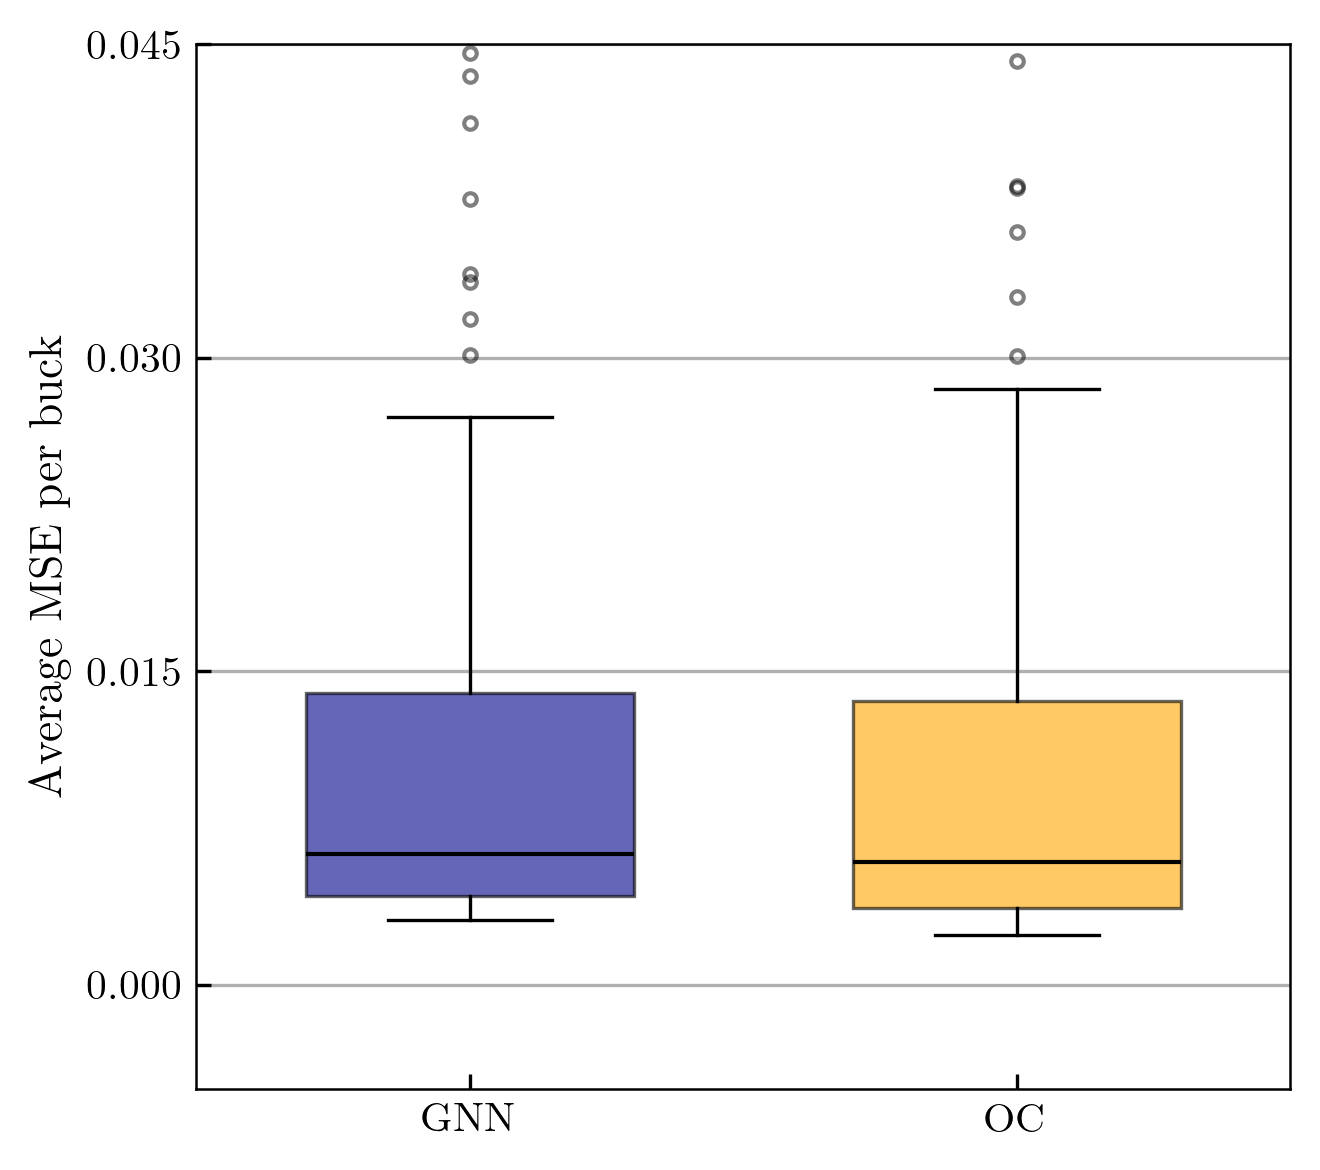

In [ ]:
def plot_mse_boxplot(mse_gnn, mse_oc):
    fig, ax = plt.subplots(
        figsize=(4.0, 4.0),
        dpi=300
    )

    data = [mse_gnn, mse_oc]
    labels = [r'GNN', r'OC']

    # Plot boxplot
    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        medianprops=dict(color='black', linewidth=1.0),
        boxprops=dict(facecolor='lightgray', linewidth=0.8),
        whiskerprops=dict(color='black', linewidth=0.8),
        capprops=dict(color='black', linewidth=0.8),
        flierprops=dict(marker='o', color='red', markersize=3, alpha=0.5)
    )

    # Customize colors to match previous plots
    colors = ['darkblue', 'orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_ylabel(r'Average MSE per buck')
    ax.grid(True, axis='y')
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

    fig.tight_layout()
    return fig
def plot_mse_boxplot_scaled(mse_gnn, mse_oc):
    fig, ax = plt.subplots(
        figsize=(4.5, 4.0), 
        dpi=300
    )

    data = [mse_gnn, mse_oc]
    labels = [r'GNN', r'OC']

    # Plot boxplot
    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        medianprops=dict(color='black', linewidth=1.0),
        boxprops=dict(facecolor='lightgray', linewidth=0.8),
        whiskerprops=dict(color='black', linewidth=0.8),
        capprops=dict(color='black', linewidth=0.8),
        flierprops=dict(marker='o', color='red', markersize=3, alpha=0.5),
        widths=0.6  
    )

    # Customize colors to match previous plots
    colors = ['darkblue', 'orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # Y-axis clipping / scaling
    ax.set_ylim(top=0.045)  
    # Optional: rescale ticks automatically (same effect)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

    ax.set_ylabel(r'Average MSE per buck')
    ax.grid(True, axis='y')

    fig.tight_layout()
    return fig

fig = plot_mse_boxplot_scaled(mse_gnn, mse_oc)

plt.show()

C:\Users\jakobeit\AppData\Local\Temp\ipykernel_1764\667126673.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


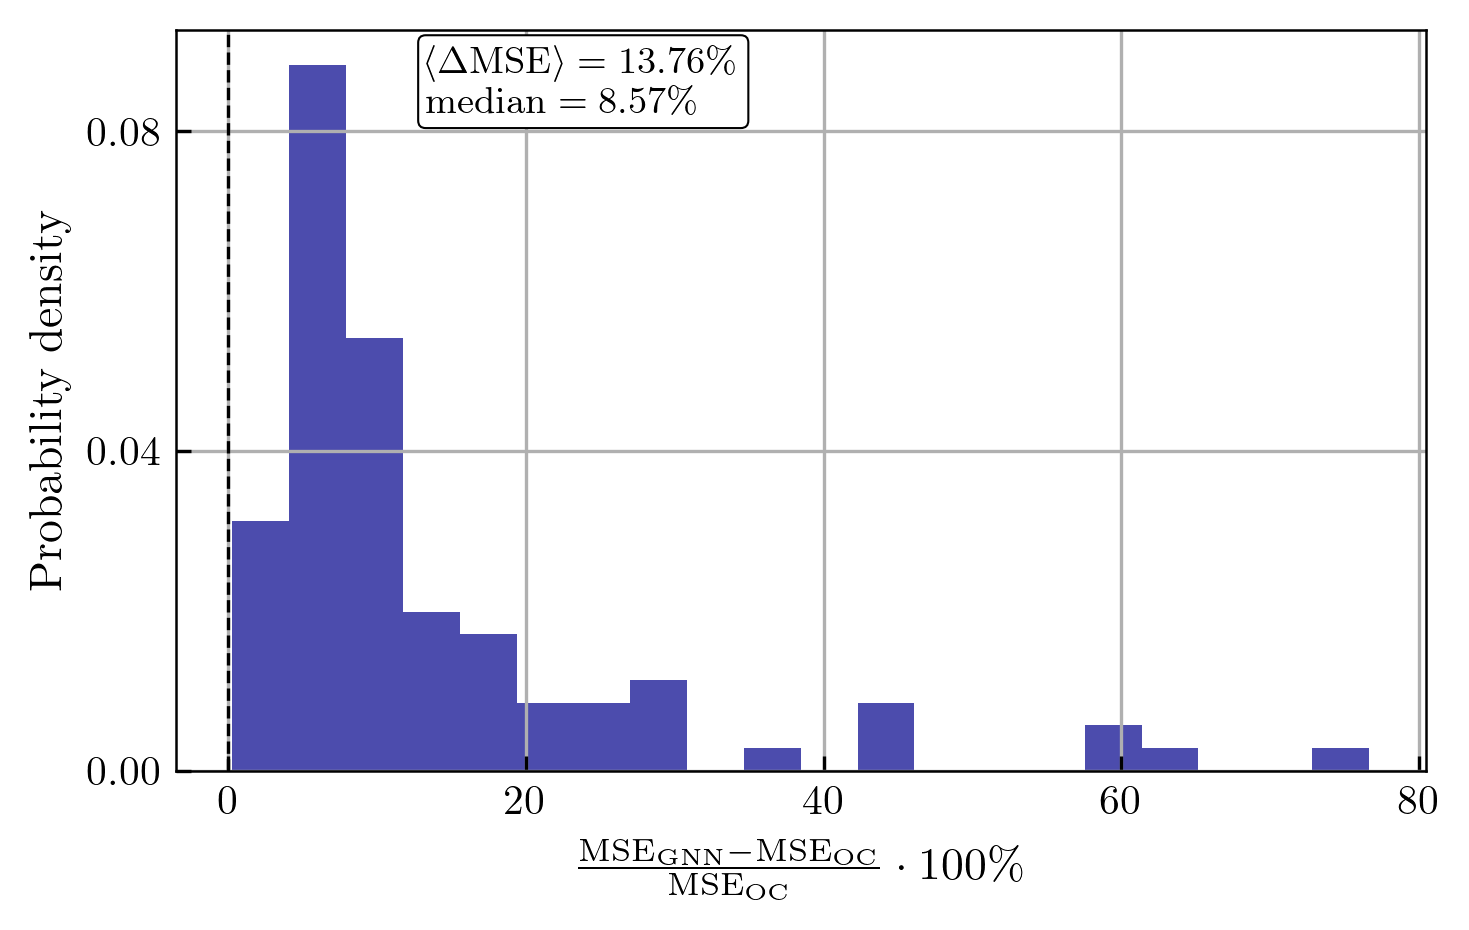

In [32]:
mse_rel = 100.0 * (mse_gnn - mse_oc) / mse_oc
def plot_mse_relative_difference_histogram(mse_gnn, mse_oc):
    mse_rel = 100.0 * (mse_gnn - mse_oc) / mse_oc

    fig, ax = plt.subplots(
        figsize=(5.0, 3.2),
        dpi=300
    )

    bins = 20

    ax.hist(
        mse_rel,
        bins=bins,
        density=True,
        color='darkblue',
        alpha=0.7
    )

    ax.axvline(
        0.0,
        color='black',
        linestyle='--',
        linewidth=0.8
    )

    ax.set_xlabel(r'$\frac{\mathrm{MSE}_{\mathrm{GNN}} - \mathrm{MSE}_{\mathrm{OC}}}{\mathrm{MSE}_{\mathrm{OC}}} \cdot 100\%$')
    ax.set_ylabel(r'Probability density')

    # Annotate mean / median for quick visual reference
    mean_rel = float(jnp.mean(mse_rel))
    median_rel = float(jnp.median(mse_rel))
    ax.text(
        0.2, 0.98,
        rf"$\langle \Delta \mathrm{{MSE}} \rangle = {mean_rel:.2f}\%$" "\n"
        rf"$\mathrm{{median}} = {median_rel:.2f}\%$",
        transform=ax.transAxes,
        va='top',
        ha='left',
        fontsize=9,
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="white",
            edgecolor="black",
            linewidth=0.5
        )
    )

    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

    fig.tight_layout()
    return fig

fig = plot_mse_relative_difference_histogram(mse_gnn, mse_oc)
fig.show()